In [14]:
from quspin.operators import hamiltonian  # operators
from quspin.basis import boson_basis_1d  # Hilbert space boson basis
from quspin.basis import tensor_basis, spinless_fermion_basis_1d  # Hilbert spaces
from quspin.basis import spin_basis_1d  # Hilbert space spin basis
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function, division
from quspin.tools.measurements import obs_vs_time  # t_dep measurements
from quspin.tools.Floquet import Floquet_t_vec
from quspin.tools.evolution import evolve  # ODE evolve tool
from quspin.operators import hamiltonian  # operators
from quspin.basis import boson_basis_1d  # Hilbert space boson basis
from quspin.basis import tensor_basis, spinless_fermion_basis_1d  # Hilbert spaces
from quspin.basis import spin_basis_1d  # Hilbert space spin basis

### Build basis and Hamiltonian

In [15]:
Nsites = 2
Nbosons = 2
###### parameters
L_spin = Nsites - 1
L_modes = Nsites  # system size
cutoff = Nbosons + 1  #sites+2
h = 1  # field strength
t = 1

### Build projector onto gauge conserving basis

In [16]:
from qutip import *
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import eigsh
from quspin.operators import hamiltonian  # operators
from quspin.basis import boson_basis_1d  # Hilbert space boson basis
from quspin.basis import tensor_basis, spinless_fermion_basis_1d  # Hilbert spaces
from quspin.basis import spin_basis_1d  # Hilbert space spin basis


def flip(s):
    if s == '+':
        return '-'
    elif s == '-':
        return '+'


def isodd(n):
    return int(n) % 2 == True


def binom(n, k):
    return np.math.factorial(n) // np.math.factorial(k) // np.math.factorial(n - k)


def gaugeFixedBasis(Nsites, Nbosons):
    bosonStates = []
    gaugefixedStates = []
    # Let's first list out all possible boson occupations.
    # We can do this by looping through all numbers and putting it into base Nbosons
    for number in np.arange((Nbosons + 1) ** Nsites):
        bosonString = np.base_repr(number, base=Nbosons + 1)
        # print(bosonString)
        bosonString = '0' * (Nsites - len(bosonString)) + bosonString

        # check total boson number
        if sum([int(c) for c in bosonString]) == Nbosons:
            bosonStates.append(bosonString)

    # Now loop through each state and insert appropriate qubit state which fixes the gauge condition to +1
    for state in bosonStates:
        gaugefixedstate = ''
        for site in np.arange(len(state) - 1):
            thisn = state[site]
            gaugefixedstate += thisn
            if site == 0:  # For the first site
                thislink = '-' * (isodd(thisn)) + '+' * (not isodd(thisn))
            else:  # For all other sites
                if isodd(thisn):
                    thislink = flip(lastlink)
                else:
                    thislink = lastlink
            gaugefixedstate += thislink
            lastlink = thislink
        gaugefixedstate += state[-1]
        gaugefixedStates.append(gaugefixedstate)
    return gaugefixedStates


# Now that we have the gauge fixed basis vectors, we could proceed in a few different ways. The harder
# thing would be to build the Hamiltonian and all operators explicitly in this basis. While probably
# more efficient for very large systems, we could also just build projectors that take us from
# the full Hilbert space down to the gauge fixed Hilbert space. Let's do that here in Qutip:

def siteState(c, Nbosons):
    print("site state ", basis(Nbosons + 1, int(c)))
    #print(basis_boson)
    return basis(Nbosons + 1, int(c))


def linkState(c):
    if c == '+':
        print("link state ", (basis(2, 0) + basis(2, 1)).unit())
        return (basis(2, 0) + basis(2, 1)).unit()
    elif c == '-':
        return (basis(2, 0) - basis(2, 1)).unit()


basisStatesList = gaugeFixedBasis(Nsites, Nbosons)
#print(basisStatesList)
# Build basis vectors in full Hilbert space
fullBasis = []
for state in basisStatesList:  # Loop through each basis state
    basisVector = []
    for ind in np.arange(len(state)):  # Loop through each site/link from left to right
        c = state[ind]
        #print("c ",c)
        if isodd(ind):
            basisVector.append(linkState(c))
    for ind in np.arange(len(state)):  # Loop through each site/link from left to right
        c = state[ind]
        if ind % 2 == 0:
            basisVector.append(siteState(c, Nbosons))
            print(siteState(c, Nbosons))

    # Now take tensor product to get the full basisVector
    fullBasis.append(tensor(basisVector))

#print(fullBasis)

# Now build projectors onto the gauge fixed Hilbert space
P_gaugefixed = 0
for i in np.arange(len(fullBasis)):
    P_gaugefixed += basis(len(fullBasis), i) * fullBasis[i].dag()

P_sparse = P_gaugefixed.data

link state  Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.70710678]
 [0.70710678]]
site state  Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]]
site state  Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]]
Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]]
site state  Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [1.]]
site state  Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [1.]]
Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [1.]]
site state  Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[0.]
 [1.]
 [0.]]
site state  Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[0.]
 [1.]
 [0.]]
Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj da

In [17]:
# building the two bases to tensor together
basis_spin = spin_basis_1d(L=L_spin)
basis_boson = boson_basis_1d(L=L_modes, sps=cutoff)
print(basis_boson)
basis = tensor_basis(basis_spin, basis_boson)
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
     0.         |2 2>           8  
     1.         |2 1>           7  
     2.         |2 0>           6  
     3.         |1 2>           5  
     4.         |1 1>           4  
     5.         |1 0>           3  
     6.         |0 2>           2  
     7.         |0 1>           1  
     8.         |0 0>           0  
reference states: 
array index   /   Fock state   /   integer repr. 
	 0.         |1>           1         |2 2>           8  
	 1.         |1>           1         |2 1>           7  
	 2.         |1>           1         |2 0>           6  
	 3.         |1>           1         |1 2>           5  
	 4.         |1>           1         |1 1>           4  
	 5.         |1>           1         |1 0>           3  
	 6.         |1>           1         |0 2>           2  
	 7.         |1>           1         |0 1>           1  
	 8.         |1>           1         |0 0>           0  
	 9.         |0>         

### Build Hamiltonian and calculate ground state

#### Hopping dominates: ground state is (1/2 |2+0> + 1/2 |0+2> + 1/sqrt(2) |1-1>)

In [18]:
hop = [[-10, i, i, i + 1] for i in range(L_modes - 1)]
# hop+=[[-1.0,L_modes-1,L_modes-1,0]]
field = [[0, i] for i in range(L_spin)]
static = [["z|+-", hop], ["z|-+", hop], ["x|", field]]
###### setting up operators
# set up hamiltonian dictionary and observable (imbalance I)
no_checks = dict(check_pcon=False, check_symm=False, check_herm=False)
H = hamiltonian(static, [], basis=basis, **no_checks)
H_sparse = H.tocsr()
Hgaugefixed = P_sparse @ H_sparse @ P_sparse.T.conj()
E, psi0 = eigsh(Hgaugefixed, k=1, which='SA')
print(np.angle(psi0[0])-np.angle(psi0[1]),np.angle(psi0[2])-np.angle(psi0[1]),np.angle(psi0[0])-np.angle(psi0[2]))
print(np.abs(psi0[0]),np.abs(psi0[1]),np.abs(psi0[2]))

[7.07767178e-16] [5.96744876e-16] [1.11022302e-16]
[0.5] [0.70710678] [0.5]


### define initial state (ground state of X field)

In [23]:
##### create model
field = [[-h,i] for i in range(L_spin)]
# density = [[0.01,i,i] for i in range(L_modes)]
static=[["x|",field]]#,["|nn",density]]
###### setting up operators
# set up hamiltonian dictionary and observable (imbalance I)
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
H1 = hamiltonian(static,[],basis=basis,**no_checks)

H = hamiltonian(static, [], basis=basis, **no_checks)
H_sparse = H.tocsr()
Hgaugefixed = P_sparse @ H_sparse @ P_sparse.T.conj()
_,psi = eigsh(Hgaugefixed,k=1, which='SA')
# P=P_gaugefixed.full()
# psi=np.dot(P.T.conj(),psi)

In [3]:
# ##### define initial state #####
# #Spin - find index of spin state |01>
# ispin = basis_spin.index("01")
# #Boson - find index of Fock state |20>
# iboson = basis_boson.index("02")
# # Ns is the size of the Hilbert space
# psispin = np.zeros(basis_spin.Ns,dtype=np.float64) # for 2 bosons in 2 modes Ns=3 ("20","11","02")
# psispin[ispin] = 1.0
# psiboson = np.zeros(basis_boson.Ns,dtype=np.float64)
# psiboson[iboson] = 1.0
# psi=np.kron(psispin,psiboson)

defining via product state (not in use)

In [22]:
##### define initial state #####
psispin=(1/np.sqrt(2))*np.array([1,1])
#Boson - find index of Fock state |20>
iboson = basis_boson.index("010")
# Ns is the size of the Hilbert space
psiboson = np.zeros(basis_boson.Ns,dtype=np.float64)
psiboson[iboson] = 1.0
psi=np.kron(psispin,psiboson)

##### Check state we just made (not in use)

In [24]:
field = [[1.0,0]] #second index chooses which spin or mode to check (ie. 0 is the 1st mode, 1 is the second and same for spins)
static=[["|n",field]] #z| checks magnetization of spins, |n checks boson number in modes
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
H_check = hamiltonian(static,[],basis=basis,**no_checks)
print(np.dot(psi.conj().T,H_check.dot(psi)))

ValueError: matrix dimension mismatch with shapes: (162,) and (648, 648).

### Time evolve

get real groundstate

In [30]:
hop=[[-1.0,i,i,i+1] for i in range(L_modes-1)]
# DENSITY AT ZERO - density should be converged for 0.01
# density = [[0.01,i,i] for i in range(L_modes)]
field = [[h,i] for i in range(L_spin)]
# static=[["z|+-",hop],["z|-+",hop],["x|",field]]
static=[["z|+-",hop],["z|-+",hop],["x|",field]]#,["|nn",density]]
###### setting up operators
# set up hamiltonian dictionary and observable (imbalance I)
no_checks = dict(check_pcon=False, check_symm=False, check_herm=False)
H = hamiltonian(static, [], basis=basis, **no_checks)
H_sparse = H.tocsr()
Hgaugefixed = P_sparse @ H_sparse @ P_sparse.T.conj()
_,psi1 = eigsh(Hgaugefixed, k=1, which='SA')
# psi1=np.dot(P.T.conj(),psi1)[:,0]

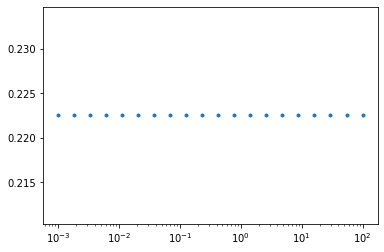

In [31]:
##### create model
def drive(t,t_0):
    return t/t_0

res=[]
t0s=np.logspace(-3,2,20)
for t0 in t0s:
    drive_args=[t0]
    hop=[[-1.0,i,i,i+1] for i in range(L_modes-1)]
    density = [[0.01,i,i] for i in range(L_modes)]
    field = [[h,i] for i in range(L_spin)]
    # static=[["z|+-",hop],["z|-+",hop],["x|",field]]
    # set up hamiltonian dictionary and observable (imbalance I)
    no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
    static=[["x|",field],["|nn",density]]
    dynamic=[]
    Hs = hamiltonian(static,dynamic,basis=basis,**no_checks)
    static = []
    dynamic = [["z|+-",hop,drive,drive_args],["z|-+",hop,drive,drive_args]]
    Hd = hamiltonian(static,dynamic,basis=basis,**no_checks)
    Hs = Hs.tocsr()
    Hd = Hd.tocsr()

    Hsgaugefixed = P_sparse @ Hd @ P_sparse.T.conj()
    Hdgaugefixed = P_sparse @ Hd @ P_sparse.T.conj()

    def adiabatic(time,phi):
        phi_dot = -1j*Hsgaugefixed@phi
        phi_dot += -1j*drive(time,t0)*Hdgaugefixed@phi
        return phi_dot

    # psi_t=H.evolve(psi,0.0,[t0],iterate=False,rtol=1E-9,atol=1E-9)
    psi_t=evolve(psi,0.0,[t0],adiabatic,iterate=False,rtol=1E-9,atol=1E-9)
    # calculate fidelity
    res.append(np.abs(np.dot(psi_t[:,0,0].conj(),psi1))**2)
plt.plot(t0s,res,'.')
plt.xscale('log')

plot occupations (not in use)

In [11]:
##### create model
res=[]
N_timesteps=20
t0s=np.logspace(-3,1,N_timesteps)
for t0 in t0s:
    hop=[[-1.0,i,i,i+1] for i in range(L_modes-1)]
    field = [[-h,i] for i in range(L_spin)]
    no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
    static=[["x|",field],["z|+-",hop],["z|-+",hop]]
    dynamic=[]
    H = hamiltonian(static,dynamic,basis=basis,**no_checks)
    ###### setting up operators

    H = H.tocsr()

    def adiabatic(time,phi):
        phi_dot = -1j*H@phi
        return phi_dot

    # psi_t=H.evolve(psi,0.0,[t0],iterate=False,rtol=1E-9,atol=1E-9)
    psi_t=evolve(psi1,0.0,[t0],adiabatic,iterate=False,rtol=1E-9,atol=1E-9)

In [18]:
obs_args={"basis":basis,"check_herm":False,"check_symm":False}
n=hamiltonian([["|n", [[1.0,1]] ]],[],dtype=np.float64,**obs_args)
Obs_t = obs_vs_time(psi_t,t,{"n":n})
O_n = Obs_t["n"]
print(O_n)

[1.16016406+0.j]


/tmp/ipykernel_2810/666753308.py:2: UserWarning: Test for particle conservation not implemented for <class 'quspin.basis.tensor.tensor_basis'>, to turn off this warning set check_pcon=False in hamiltonian
  n=hamiltonian([["|n", [[1.0,1]] ]],[],dtype=np.float64,**obs_args)


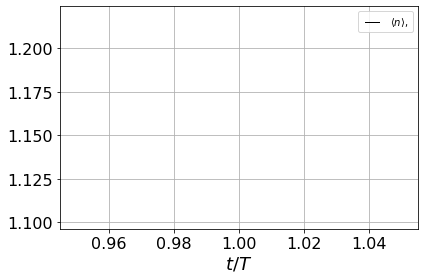

In [13]:
##### plot results #####
import matplotlib.pyplot as plt
import pylab
str_n = "$\\langle n\\rangle,$"
fig = plt.figure()
plt.plot(t,np.real(O_n),"k",linewidth=1,label=str_n)
plt.xlabel("$t/T$",fontsize=18)
# plt.ylim([-1.1,1.4])
plt.legend(loc="upper right",ncol=5,columnspacing=0.6,numpoints=4)
plt.tick_params(labelsize=16)
plt.grid(True)
plt.tight_layout()
#plt.savefig('example3.pdf', bbox_inches='tight')
plt.show()
# plt.close()

In [ ]:
plt.pcolormesh(np.arange(Nsites+1)-Nsites//2-0.5,np.arange(N_timesteps+1)*dt,occupations[0],cmap=matplotlib.cm.Blues,linewidth=0,rasterized=True)
plt.title("Mode occupation: gauge field flipping dominates")
plt.xlabel("Modes")
plt.ylabel("Time")
plt.colorbar()